
# 01 — Data Preprocessing & Cleaning (UCI Heart Disease)

This notebook:
- **Fetches** the UCI Heart Disease dataset via `ucimlrepo` (ID=45), with a fallback to `data/heart_disease.csv` if offline.
- **Cleans** the data (types, missing values, outliers handling placeholder).
- **Creates target (binary)**: 0 = no disease, 1 = disease (num > 0).
- **Saves** a cleaned CSV to `data/heart_disease_clean.csv` for downstream notebooks.
- **Generates EDA** plots in `results/`.


In [1]:
import os, sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

warnings.filterwarnings("ignore")
sns.set_context("talk")

PROJECT_ROOT = Path.cwd().parents[0]
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(exist_ok=True)
RAW_CSV = DATA_DIR / "heart_disease.csv"
CLEAN_CSV = DATA_DIR / "heart_disease_clean.csv"

print("Project root:", PROJECT_ROOT)
print("Data dir:", DATA_DIR)
print("Results dir:", RESULTS_DIR)


Project root: C:\Users\Moamen\Desktop\Heart_Disease_Project\Heart_Disease_Project
Data dir: C:\Users\Moamen\Desktop\Heart_Disease_Project\Heart_Disease_Project\data
Results dir: C:\Users\Moamen\Desktop\Heart_Disease_Project\Heart_Disease_Project\results


In [2]:

# --- 1) Load data
# Preferred: fetch via ucimlrepo (ID=45). Fallback: local CSV at data/heart_disease.csv
!pip install ucimlrepo
def load_uci_heart_via_ucimlrepo():
    try:
        from ucimlrepo import fetch_ucirepo
        heart = fetch_ucirepo(id=45)  # Heart Disease
        X = heart.data.features
        y = heart.data.targets
        df = pd.concat([X, y], axis=1)
        print("Loaded via ucimlrepo (ID=45). Shape:", df.shape)
        return df
    except Exception as e:
        print("ucimlrepo unavailable or failed:", e)
        return None

def load_local_csv():
    if RAW_CSV.exists():
        df = pd.read_csv(RAW_CSV)
        print("Loaded local CSV:", RAW_CSV, "Shape:", df.shape)
        return df
    return None

df = load_uci_heart_via_ucimlrepo()
if df is None:
    df = load_local_csv()

if df is None:
    raise FileNotFoundError("""
No data found.
- Try: `pip install ucimlrepo` and re-run, or
- Place a CSV at data/heart_disease.csv
""")
    
display(df.head())
print(df.dtypes)
print("Initial shape:", df.shape)



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Loaded via ucimlrepo (ID=45). Shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
num           int64
dtype: object
Initial shape: (303, 14)


In [3]:

# --- 2) Standardize column names & target
# Common schemas:
# - Kaggle-like: columns include 'age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal, target'
# - UCI raw: 'num' target ranges 0..4 (presence if >0)

df.columns = [str(c).strip().lower() for c in df.columns]

# If 'num' exists but 'target' doesn't, create target as binary
if 'target' not in df.columns and 'num' in df.columns:
    df['target'] = (df['num'] > 0).astype(int)

# If target exists as string categories, coerce
if 'target' in df.columns:
    df['target'] = pd.to_numeric(df['target'], errors='coerce')

# Replace common missing markers
df = df.replace({'?': np.nan, 'NA': np.nan, 'na': np.nan, 'None': np.nan, 'none': np.nan})

print("Columns after normalization:", list(df.columns))
print(df[['target']].head())


Columns after normalization: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num', 'target']
   target
0       0
1       1
2       1
3       0
4       0


In [4]:

# --- 3) Basic sanity checks
# Drop duplicate rows
before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
after = df.shape[0]
print(f"Removed duplicates: {before - after}")

# Ensure target is present and binary/integer
if 'target' not in df.columns:
    raise ValueError("Target column not found. Expected 'target' (or 'num' converted).")

# If target has values >1, binarize using >0
if df['target'].dropna().max() > 1:
    df['target'] = (df['target'] > 0).astype(int)

# Separate features/target for inspection
X_cols = [c for c in df.columns if c != 'target']
num_cols = df[X_cols].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_cols if c not in num_cols]

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)
print("Missing per column:\n", df.isna().sum().sort_values(ascending=False).head(10))


Removed duplicates: 0
Numeric columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
Categorical columns: []
Missing per column:
 ca          4
thal        2
age         0
trestbps    0
chol        0
sex         0
cp          0
restecg     0
fbs         0
thalach     0
dtype: int64


In [5]:

# --- 4) Impute missing values
!pip install scikit-learn
from sklearn.impute import SimpleImputer

# Numeric: median; Categorical: most frequent
if num_cols:
    num_imputer = SimpleImputer(strategy='median')
    df[num_cols] = num_imputer.fit_transform(df[num_cols])

if cat_cols:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Final check
print("Missing after imputation:", int(df.isna().sum().sum()))



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Missing after imputation: 0


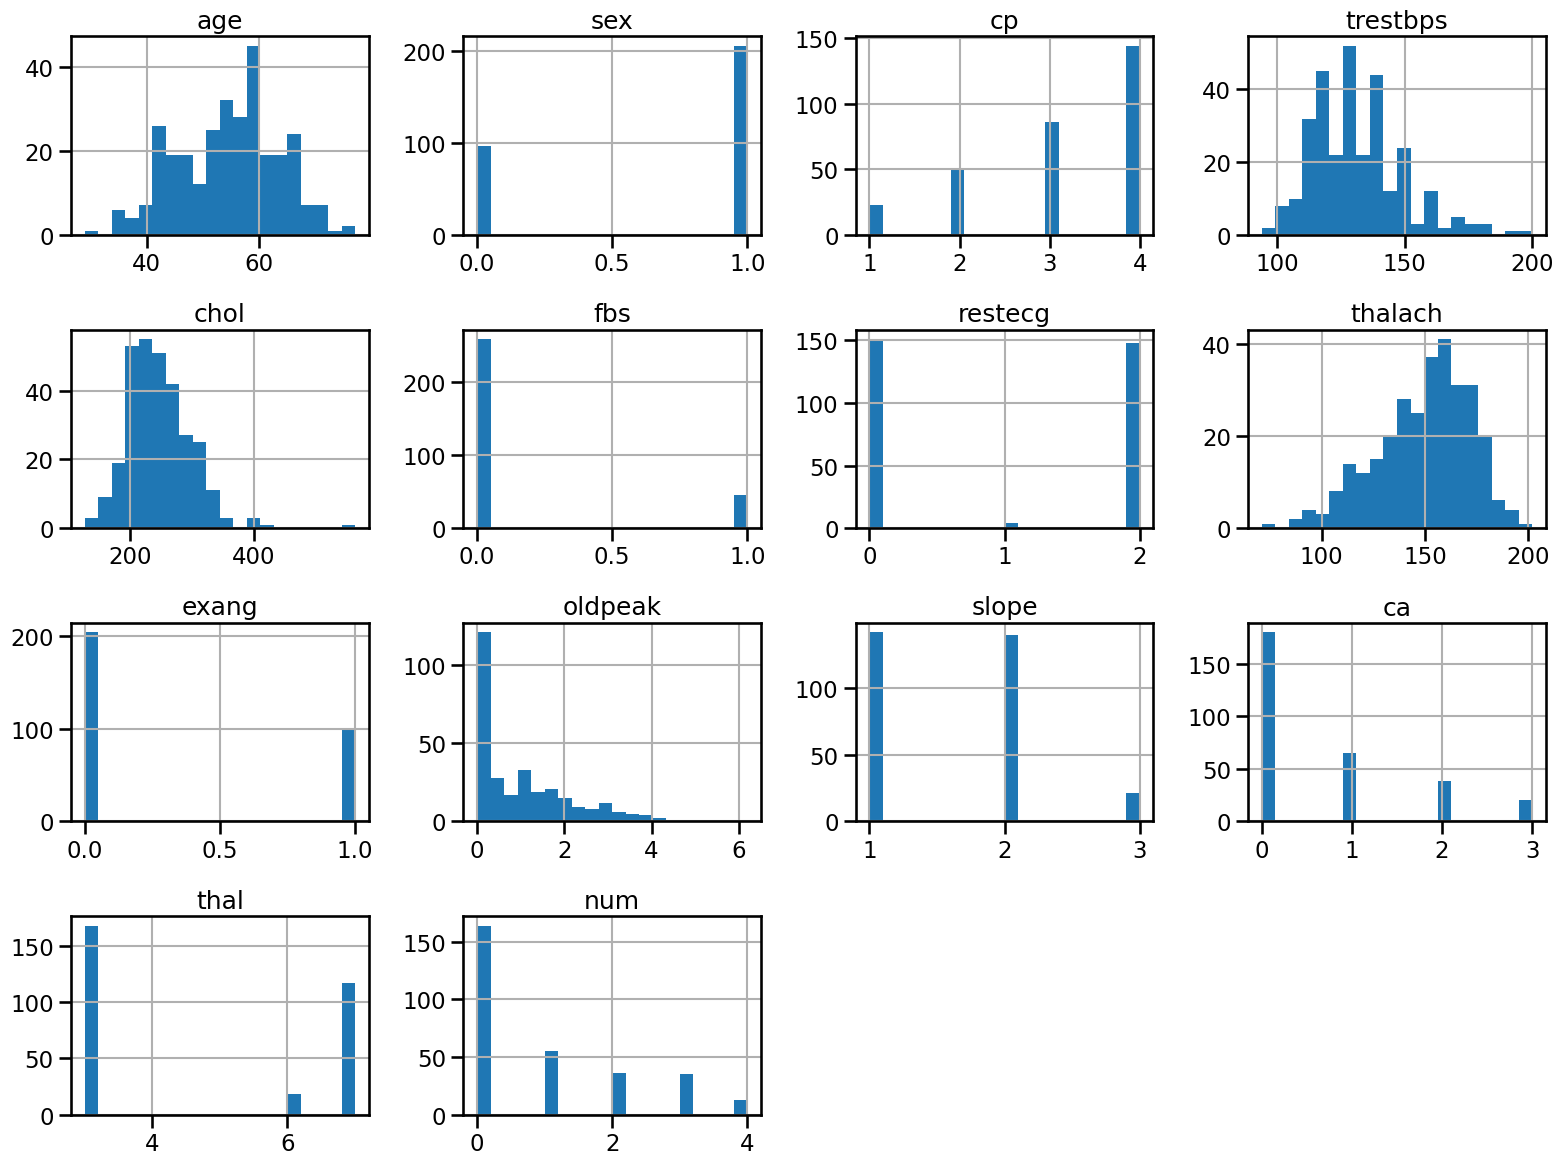

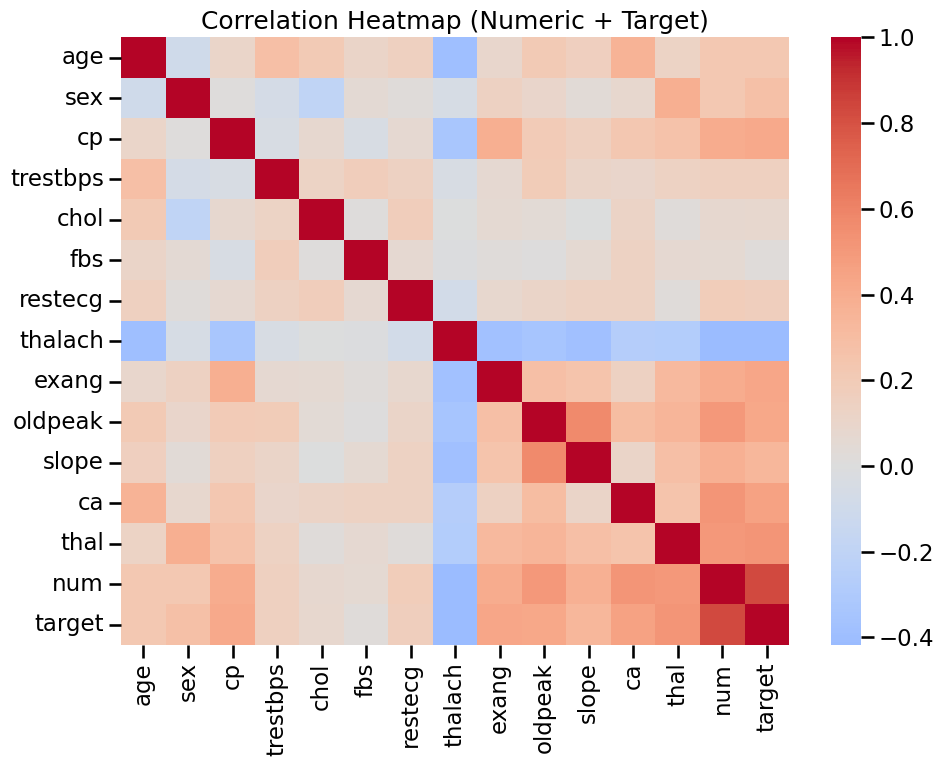

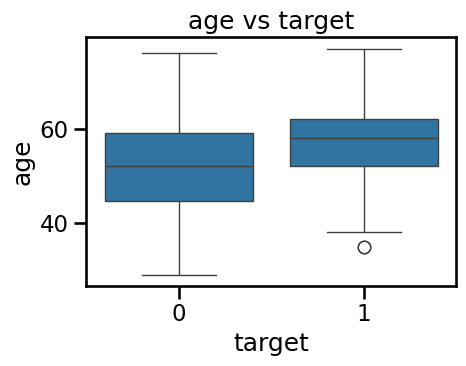

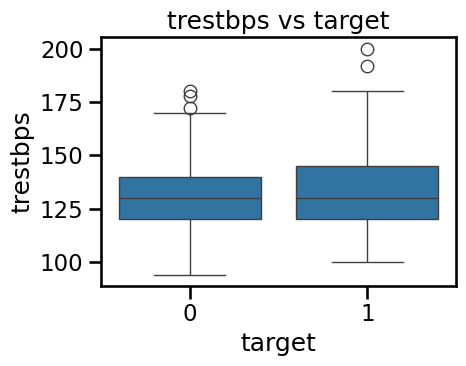

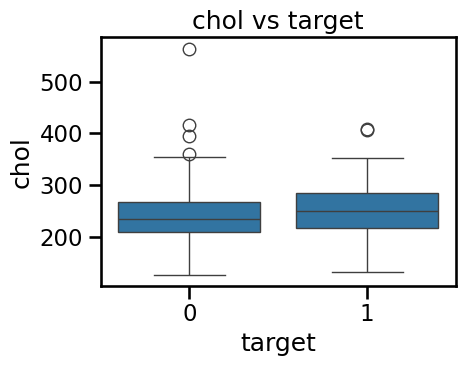

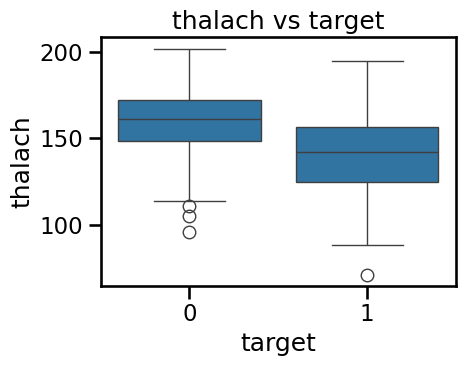

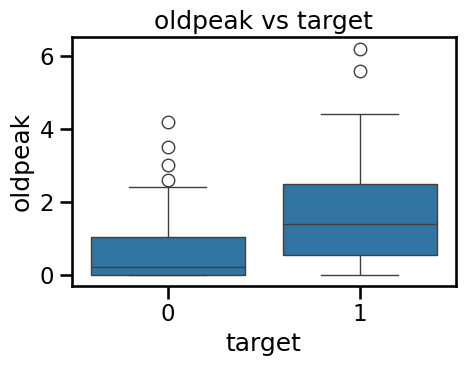

In [6]:

# --- 5) Quick EDA
# Histograms
ax = df[X_cols].hist(figsize=(16,12), bins=20)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "eda_histograms.png", dpi=150)
plt.show()

# Correlation heatmap (numeric only)
if len(num_cols) >= 2:
    plt.figure(figsize=(10,8))
    corr = df[num_cols + ['target']].corr(numeric_only=True)
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap (Numeric + Target)')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "corr_heatmap.png", dpi=150)
    plt.show()

# Boxplots for a few key features if present
for col in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
    if col in df.columns:
        plt.figure(figsize=(5,4))
        sns.boxplot(x='target', y=col, data=df)
        plt.title(f'{col} vs target')
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / f'box_{col}_vs_target.png', dpi=150)
        plt.show()


In [7]:
# --- 6) Save cleaned dataset (robust version)

from pathlib import Path

# Try to detect a valid project root (current dir, parent, or grandparent)
candidates = [
    Path.cwd().resolve(),
    Path.cwd().resolve().parent,
    Path.cwd().resolve().parent.parent
]

PROJECT_ROOT = None
for cand in candidates:
    if (cand / "results").exists() or (cand / "notebooks").exists() or (cand / "ui").exists():
        PROJECT_ROOT = cand
        break

# Fallback: just use current working directory
if PROJECT_ROOT is None:
    PROJECT_ROOT = Path.cwd().resolve()

# Define paths
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"
RAW_CSV = DATA_DIR / "heart_disease.csv"
CLEAN_CSV = DATA_DIR / "heart_disease_clean.csv"

# Ensure directories exist
DATA_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Save cleaned data
df.to_csv(CLEAN_CSV, index=False)
print("✅ Saved cleaned dataset to", CLEAN_CSV)
print("Final shape:", df.shape)

df.head()


✅ Saved cleaned dataset to C:\Users\Moamen\Desktop\Heart_Disease_Project\Heart_Disease_Project\data\heart_disease_clean.csv
Final shape: (303, 15)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0,0
